In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import itertools
import os

In [8]:
plt.rcParams["font.family"] = "serif"

In [9]:
# File path
file_path = "/home/pow_cons/power-consumption-tool/power-metrics-per-pod-realtime/data/experiment_results.csv"

# Load the dataset
data_results = pd.read_csv(file_path)
print(data_results.columns)

# Grouping and calculating mean energy consumption for each CU configuration
energy_table = (
    data_results
    .groupby(['Mbps requested', 'num_cus'])['total_energy_consumption']
    .mean()  # Use mean instead of sum to avoid artificial inflation
    .unstack()
    .fillna(0)  # Fill missing values with 0
)

# Rename columns to reflect the CU configurations
energy_table.columns = [f"{int(col)}CU" for col in energy_table.columns]

# Print the energy table
print(energy_table)



Index(['Mbps requested', 'packet length requested',
       'tot Mbps effectively received at server',
       'avg OAI-CU power consumption [W]',
       'total OAI-CU energy consumption [J]',
       'avg OAI-DU power consumption [W]',
       'total OAI-DU energy consumption [J]',
       'avg OAI-NR-UE power consumption [W]',
       'total OAI-NR-UE energy consumption [J]',
       'avg OAI-UPF power consumption [W]',
       'total OAI-UPF energy consumption [J]', 'duration_1', 'duration_2',
       'duration_3', 'duration_4', 'maxrate', 'num_cus',
       'host_energy_consumption', 'powerup_energy_consumption',
       'service_energy_consumption_J', 'total_energy_consumption'],
      dtype='object')
                        1CU          2CU          3CU          4CU
Mbps requested                                                    
20                21.067533   155.005186   321.281110   445.426990
100              119.350675   233.002012   358.651991   496.526553
300              432.507803

In [10]:
def find_intersections(df_experiment):
    # Group the data by `num_cus`
    groups = df_experiment.groupby('num_cus')
    
    # Store intersections
    intersections = []
    
    # Iterate over all combinations of `num_cus` groups
    for (group1, data1), (group2, data2) in itertools.combinations(groups, 2):
        # Sort data by `Mbps requested` for interpolation
        data1 = data1.sort_values('Mbps requested')
        data2 = data2.sort_values('Mbps requested')
        
        # Define the common range of x values
        min_common = max(data1['Mbps requested'].min(), data2['Mbps requested'].min())
        max_common = min(data1['Mbps requested'].max(), data2['Mbps requested'].max())
        
        if min_common >= max_common:
            # Skip if there's no overlap
            continue
        
        # Interpolate curves only within the common range
        f1 = interp1d(data1['Mbps requested'], data1['total_energy_consumption'], kind='linear', bounds_error=False, fill_value=np.nan)
        f2 = interp1d(data2['Mbps requested'], data2['total_energy_consumption'], kind='linear', bounds_error=False, fill_value=np.nan)
        
        # Generate values within the common range
        common_range = np.linspace(min_common, max_common, 1000)
        
        # Calculate the difference between the two curves
        diff = f1(common_range) - f2(common_range)
        
        # Find zero crossings (sign change in the difference)
        sign_changes = np.where(np.diff(np.sign(diff)))[0]
        
        # Calculate intersection points
        for idx in sign_changes:
            x_intersect = common_range[idx]
            y_intersect = f1(x_intersect)  # or f2(x_intersect), as they should be equal
            if not np.isnan(y_intersect):  # Ensure valid intersection
                intersections.append({
                    'Mbps requested': x_intersect,
                    'total_energy_consumption': y_intersect,
                    'group1': group1,
                    'group2': group2
                })
    
    # Convert intersections to a DataFrame
    return pd.DataFrame(intersections)

# Example usage
intersections_df = find_intersections(data_results)

# Print the cleaned intersections DataFrame
print(intersections_df)


   Mbps requested total_energy_consumption  group1  group2
0      300.520521         433.252001779769       1       2
1      576.076076        851.6023843929127       1       3
2      672.892893       1021.0541639822047       1       4
3     1641.061061       1944.5080429783352       2       3
4     1588.928929       1884.5408069032637       2       4
5     1529.349349       1827.7322922386202       3       4


In [11]:
# File path
file_path = "/home/pow_cons/power-consumption-tool/power-metrics-per-pod-realtime/dataset/testing_dat_1.csv"

# Load the dataset
data = pd.read_csv(file_path)

# Duplicate the dataset rows three times dynamically
data = pd.concat([data] * 1, ignore_index=True)

# Normalize the "MB_Requested" column to range 0 to 2500
new_min, new_max = 0, 2500
min_value = data["MB_Requested"].min()
max_value = data["MB_Requested"].max()

data["MB_Requested"] = (
    (data["MB_Requested"] - min_value) / (max_value - min_value) * (new_max - new_min) + new_min
)

# Example energy_table with Mbps requested values
energy_table_values = data_results["Mbps requested"].unique()  # Replace with actual `Mbps requested` values from your energy table


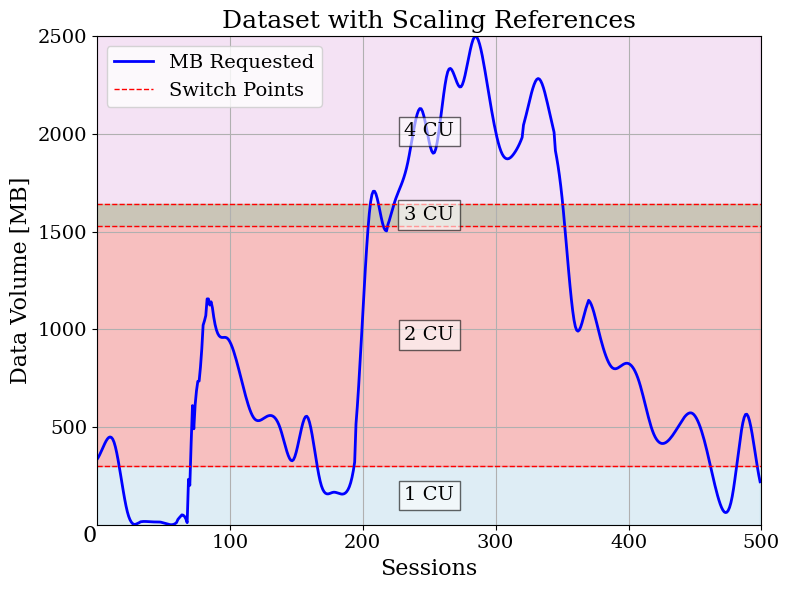

In [12]:
# Filter intersections_df to include only rows where group1 == group2 - 1
filtered_intersections = intersections_df[intersections_df['group1'] == intersections_df['group2'] - 1]

# Plot the line plot
plt.figure(figsize=(8, 6))
plt.plot(data.index, data["MB_Requested"], label="MB Requested", color="blue", linestyle="-", linewidth=2)

# Add horizontal lines for Mbps requested from the filtered data
previous_mbps = 0  # Variable to store the previous 'Mbps requested' value
last_mbps = None  # Variable to store the last 'Mbps requested' value

# Hard-coded colors for different regions
color_1 = "#5CA8D1"    # Light Blue for the first region
color_2 = "lightcoral"   # Light Coral for the second region
color_3 = "lightgreen"   # Light Green for the third region
color_4 = "plum"         # Plum for the fourth region

# CU count for each region (example values; adjust as needed)
cus_per_region = ["1 CU", "2 CU", "3 CU", "4 CU"]

# Manually plot the red line and label it for the legend
red_line_label = "Switch Points"
for i, mbps in enumerate(filtered_intersections['Mbps requested']):
    if previous_mbps is not None:
        # Color the area between previous_mbps and current mbps based on hardcoded colors
        if i == 0:
            plt.fill_between(data.index, 0, mbps, color=color_1, alpha=0.2)
        elif i == 1:
            plt.fill_between(data.index, previous_mbps, mbps, color=color_2, alpha=0.5)
        elif i == 2:
            plt.fill_between(data.index, previous_mbps, mbps, color=color_3, alpha=0.5)
        elif i == 3:
            plt.fill_between(data.index, previous_mbps, mbps, color=color_4, alpha=0.5)
        
        # Annotate the number of CUs in the middle of the region
        region_midpoint = (previous_mbps + mbps) / 2
        plt.text(data.index[len(data) // 2], region_midpoint, cus_per_region[i],
                 fontsize=14, color="black", ha="center", va="center", bbox=dict(facecolor='white', alpha=0.6))

    # Plot the red horizontal line and label it for the legend
    plt.axhline(y=mbps, color="red", linestyle="--", linewidth=1, label=red_line_label if i == 0 else "")
    
    previous_mbps = mbps  # Update previous_mbps for the next iteration
    last_mbps = mbps  # Store the current mbps as the last value

# Add region between the last red line and the maximum y value
max_y_value = 2500  # Set the y-axis max value to 2500
if last_mbps is not None and last_mbps < max_y_value:
    plt.fill_between(data.index, last_mbps, max_y_value, color=color_4, alpha=0.3)
    # Annotate the last region with the number of CUs
    region_midpoint = (last_mbps + max_y_value) / 2
    plt.text(data.index[len(data) // 2], region_midpoint, cus_per_region[-1],
             fontsize=14, color="black", ha="center", va="center", bbox=dict(facecolor='white', alpha=0.6))

# Ensure axes coincide at (0,0) and set max values
plt.xlim(0, 500)   # X-axis from 0 to 500
plt.ylim(0, 2500)  # Y-axis from 0 to 2500

# Remove duplicate zeros and show a single zero diagonally
plt.xticks([tick for tick in plt.xticks()[0] if tick > 0], fontsize=14)
plt.yticks([tick for tick in plt.yticks()[0] if tick > 0], fontsize=14)

# Add a single "0" in the bottom-left corner diagonally
plt.text(0, 0, '0', fontsize=16, ha='right', va='top', transform=plt.gca().transData)

# Adding title and labels with increased font size
plt.title("Dataset with Scaling References", fontsize=18)
plt.xlabel("Sessions", fontsize=16)
plt.ylabel("Data Volume [MB]", fontsize=16)

# Add legend with increased font size, including "Switch Points"
plt.legend(fontsize=14, loc='upper left')

# Add grid and adjust layout
plt.grid(True)
plt.tight_layout()

# Save the plot to a PDF file
output_dir = "output_plots"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "dataset.pdf")
plt.savefig(output_file, format='pdf')

# Show the plot
plt.show()


In [13]:

# Interpolating energy costs based on data sizes, now generalized for any CU count
def interpolate_energy(data_size, energy_table, num_cus):
    keys = sorted(energy_table.index)  # Ensure we are using the correct index for Mbps requested
    num_cus_column = f"{num_cus}CU"  # Create the column name dynamically based on num_cus
    
    for i in range(len(keys) - 1):
        if keys[i] <= data_size < keys[i + 1]:
            # Linear interpolation
            x1, x2 = keys[i], keys[i + 1]
            y1, y2 = energy_table.loc[x1, num_cus_column], energy_table.loc[x2, num_cus_column]
            return y1 + (y2 - y1) * (data_size - x1) / (x2 - x1)
    
    # If out of bounds, use the closest value
    if data_size < keys[0]:
        return energy_table.loc[keys[0], num_cus_column]
    return energy_table.loc[keys[-1], num_cus_column]

In [14]:
# Assuming 'filtered_intersections' and 'data' are available
# Assuming `interpolate_energy` and `energy_table` are defined functions/data

data_column = "MB_Requested"  # Replace with the actual column name from your CSV
data = data[data_column].tolist()  # Extract MB requests as a list
data_scaling_factor = 5

# Scenario 1: Total energy using 1 to 4 CUs
energy_cus = {}
for num_cus in range(1, 5):  # For 1CU to 4CU
    energy_cus[num_cus] = sum(interpolate_energy(d * data_scaling_factor, energy_table, num_cus) for d in data)

# Convert filtered_intersections to a sorted DataFrame
switch_points = filtered_intersections.sort_values("Mbps requested").reset_index(drop=True)

# Scenario 2: Dynamic CU allocation based on the filtered intersections
session_interval = 1
energy_dynamic = 0

for i in range(len(data)):
    # Calculate the sum of MB for the next interval
    data_sum_next_10 = sum(data[i : i + session_interval]) * data_scaling_factor

    # Ensure switch_points is not empty and find the closest switch point
    if not switch_points.empty:
        closest_idx = (switch_points['Mbps requested'] - data_sum_next_10).abs().idxmin()
        closest_switch = switch_points.iloc[closest_idx]

        # Determine the chosen CU and corresponding total energy consumption
        chosen_cu = closest_switch['group2']  # Use the CU from the filtered intersections
        total_energy_consumption = closest_switch['total_energy_consumption']

        # Add the energy for this session dynamically based on the chosen CU
        energy_dynamic += interpolate_energy(data[i], energy_table, chosen_cu)
    else:
        print("No valid switch points available.")
        break

# Output energy for each scenario
print("Energy using 1 CU:", energy_cus[1])
print("Energy using 2 CU:", energy_cus[2])
print("Energy using 3 CU:", energy_cus[3])
print("Energy using 4 CU:", energy_cus[4])
print("Energy using dynamic CU allocation:", energy_dynamic)


Energy using 1 CU: 1538999.5834008271
Energy using 2 CU: 1224326.4022434757
Energy using 3 CU: 1188879.3277516472
Energy using 4 CU: 1156064.2785760923
Energy using dynamic CU allocation: 614212.2800250916


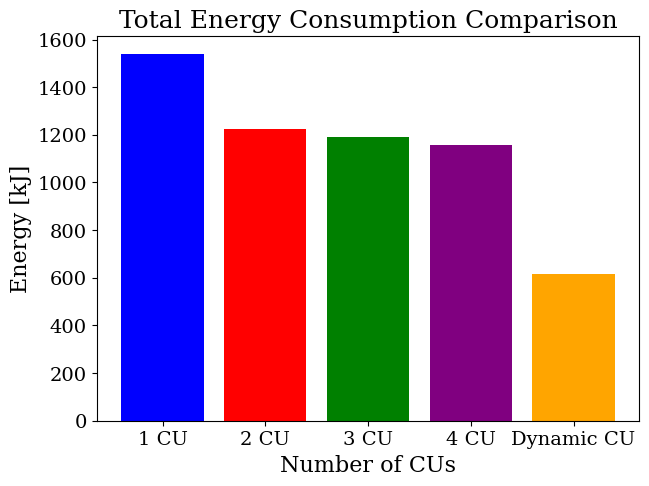

In [15]:
# Sum the energy for each CU configuration (1 to 4 CUs)
total_energy_cus = {num_cus: energy_cus[num_cus] for num_cus in range(1, 5)}

# Sum the energy for dynamic CU allocation
total_energy_dynamic = energy_dynamic  # Assuming this is already a single value

# Prepare data for the bar plot
energy_labels = ['1 CU', '2 CU', '3 CU', '4 CU', 'Dynamic CU']
energy_values = [
    total_energy_cus[1] / 1000,
    total_energy_cus[2] / 1000,
    total_energy_cus[3] / 1000,
    total_energy_cus[4] / 1000,
    total_energy_dynamic / 1000
]

# Create the bar plot to show energy consumption comparison
plt.figure(figsize=(7, 5))
plt.bar(energy_labels, energy_values, color=['blue', 'red', 'green', 'purple', 'orange'])

# Add title and axis labels with increased font size
plt.title("Total Energy Consumption Comparison", fontsize=18)  # Increased title font size
plt.xlabel("Number of CUs", fontsize=16)  # Increased font size for x-axis label
plt.ylabel("Energy [kJ]", fontsize=16)  # Increased font size for y-axis label

# Increase font size for ticks on both axes
plt.xticks(fontsize=14)  # Larger font size for x-axis ticks
plt.yticks(fontsize=14)  # Larger font size for y-axis ticks

# Save the plot to a PDF file
output_dir = "output_plots"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "benchmark_policy.pdf")
plt.savefig(output_file, format='pdf')

# Display the plot
plt.show()


In [16]:
# Find the worst-case energy consumption
worst_case_energy = max(energy_values[:-1])  # Exclude the dynamic CU policy

# Calculate energy saved
energy_saved = worst_case_energy - energy_values[-1]  # Subtract dynamic CU energy from worst case

# Calculate savings percentage
savings_percentage = (energy_saved / worst_case_energy) * 100

# Print results
print(f"Worst-Case Energy Consumption: {worst_case_energy:.2f} kJ")
print(f"Dynamic CU Policy Energy Consumption: {energy_values[-1]:.2f} kJ")
print(f"Energy Saved: {energy_saved:.2f} kJ")
print(f"Savings Percentage: {savings_percentage:.2f}%")


Worst-Case Energy Consumption: 1539.00 kJ
Dynamic CU Policy Energy Consumption: 614.21 kJ
Energy Saved: 924.79 kJ
Savings Percentage: 60.09%


In [17]:
# Find the least worst-case energy consumption (second-lowest among fixed configurations)
fixed_energy_values = energy_values[:-1]  # Exclude the dynamic CU policy
least_worst_case_energy = sorted(fixed_energy_values)[1]  # Second-lowest energy consumption

# Calculate energy saved
energy_saved_least_worst = least_worst_case_energy - energy_values[-1]

# Calculate savings percentage
savings_percentage_least_worst = (energy_saved_least_worst / least_worst_case_energy) * 100

# Print results
print(f"Least Worst-Case Energy Consumption: {least_worst_case_energy:.2f} kJ")
print(f"Energy Saved Compared to Least Worst-Case: {energy_saved_least_worst:.2f} kJ")
print(f"Savings Percentage Compared to Least Worst-Case: {savings_percentage_least_worst:.2f}%")


Least Worst-Case Energy Consumption: 1188.88 kJ
Energy Saved Compared to Least Worst-Case: 574.67 kJ
Savings Percentage Compared to Least Worst-Case: 48.34%
